In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
# from importlib import reload

In [2]:
x={1:1,0:0}
1+ (x.get(1) or 0)

2

In [3]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='25gb',threads_per_worker=14,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

In [4]:
from cov_3X2 import *
from fisher import *

In [5]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [6]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [7]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [8]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [9]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971166462048332

In [10]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [11]:
cov_shear=np.genfromtxt('/home/deep/repos/covariance_testing/data/cosmolike_cov_Y3ish/cov_y3_mcal_emu_final.txt')
covG_shear=np.genfromtxt('/home/deep/repos/covariance_testing/data/cosmolike_cov_Y3ish/cov_y3_mcal_emu_final.txt') 
# covNG_shear=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_shear_shear_covNG',) 

l_min0=20
l_max0=15000
nl0=20
l_bins=np.logspace(np.log10(l_min0),np.log10(l_max0),nl0+1)
lb=0.5*(l_bins[1:]+l_bins[:-1])

lb15=np.tile(lb,15)
x=lb15<3000
covG_shear=covG_shear[:,2].reshape(900,900)[:400,:400]
cov_shear=cov_shear[:,2].reshape(900,900)[:400,:400]
# covNG_shear=covNG_shear[x].T[x].T

x=lb<3000
lb=lb[x]
l_bins=l_bins[:16]

In [12]:
#Setup redshift bins
source_f='/home/deep/repos/covariance_testing/data/cosmolike_cov_Y3ish/source.nz'
zmin=0
zmax=3.5

nbins=4  # Number of tomographic bins
zs_bins=DES_bins(fname=source_f)

In [13]:
f_sky=5000./(4*np.pi/d2r**2)
# f_sky=4182./(4*np.pi/d2r**2)

In [14]:
f_sky*4*np.pi

1.5230870989335428

In [170]:
th,np.linspace(th_min,th_max,n_th_bins*100)

(array([0.04166667, 0.04176277, 0.04185909, ..., 4.14751302, 4.15707881,
        4.16666667]),
 array([0.04166667, 0.0437302 , 0.04579373, ..., 4.1625396 , 4.16460313,
        4.16666667]))

In [246]:
do_xi=True
bin_xi=True
do_cov=True
bin_cl=False
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [247]:
np.log10(4e5)/np.log10(4e4)

1.2172939948380468

In [256]:
#Hankel Transform setup
l_max=4e4
l_maxW=6e4
l_min=2
# l0=np.arange(l_min,l_maxW)   #np.arange(l_min,l_max)
l0=np.logspace(np.log10(l_min),np.log10(l_maxW),6.e3)
# l0=np.sort(np.append(l0,np.logspace(np.log10(l_maxW),np.log10(l_maxW*10),1.e3)))
l0=np.unique(np.int32(l0))   #np.arange(l_min,l_max)
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [257]:
l0.shape

(3278,)

In [258]:
use_window=False
do_sample_variance=True
SSV_cov=False
tidal_SSV=True
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [259]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [260]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [129]:
#use redshift bins from power spectrum part
XI_H =cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,zg_bins=None,l_bins=l_bins,
              do_sample_variance=do_sample_variance,use_window=use_window,
              power_spectra_kwargs=power_spectra_kwargs,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins,sigma_gamma=sigma_gamma)#ns=np.inf)

# XI_H2 =cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,zg_bins=None,l_bins=l_bins,do_sample_variance=do_sample_variance,use_window=use_window,
#                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs,f_sky=f_sky,HT=XI_H.HT,
#                bin_xi=bin_xi,theta_bins=th_bins,sigma_gamma=sigma_gamma*np.sqrt(2))#ns=np.inf)

08:10:31 WARNING:cross covariance not implemented with Hankel Transform. m1_m2s: [(2, 2), (2, -2)]
08:10:31 INFO:nr:728
08:10:39 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 41000
08:10:39 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 42000
08:10:40 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 43000
08:10:40 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 44000
08:10:40 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 45000
08:10:40 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 46000
08:10:40 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 47000
08:10:40 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 48000
08:10:40 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 49000
08:10:40 INFO:nr:728


In [261]:
# Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': l0,'theta': th*d2r,'m1_m2':[(2,2),(2,-2)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
                do_sample_variance=do_sample_variance,use_window=use_window,
                power_spectra_kwargs=power_spectra_kwargs,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,sigma_gamma=sigma_gamma,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 647 ms, sys: 2.27 s, total: 2.92 s
Wall time: 12.6 s


In [262]:
corr=('shear','shear')

In [263]:
%time xiHG=XI_H.xi_tomo()
# %time xiHG2=XI_H2.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo()

CPU times: user 61.6 ms, sys: 6.68 ms, total: 68.3 ms
Wall time: 64.6 ms
Note: redshifts have been re-sorted (earliest first)
CPU times: user 4.87 s, sys: 117 ms, total: 4.99 s
Wall time: 942 ms


In [133]:
%time clG=XI_W_L.cl_tomo()
%time clH=XI_H.cl_tomo()

CPU times: user 44.4 ms, sys: 6.68 ms, total: 51.1 ms
Wall time: 46.5 ms
CPU times: user 45.1 ms, sys: 6 µs, total: 45.1 ms
Wall time: 42.7 ms


In [134]:
clsH.shape,XI_H.HT.l[(2,-2)].shape

((49000,), (49000,))

In [135]:
cls=clG['cl'][('shear','shear')][(0,0)].compute()
clsH=clH['cl'][('shear','shear')][(0,0)].compute()[:49000]

thH,xiH=XI_H.HT.projected_correlation(l_cl=XI_H.HT.l[(2,-2)],cl=clsH,m1_m2=(2,-2))

In [136]:
dl=np.gradient(l0)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


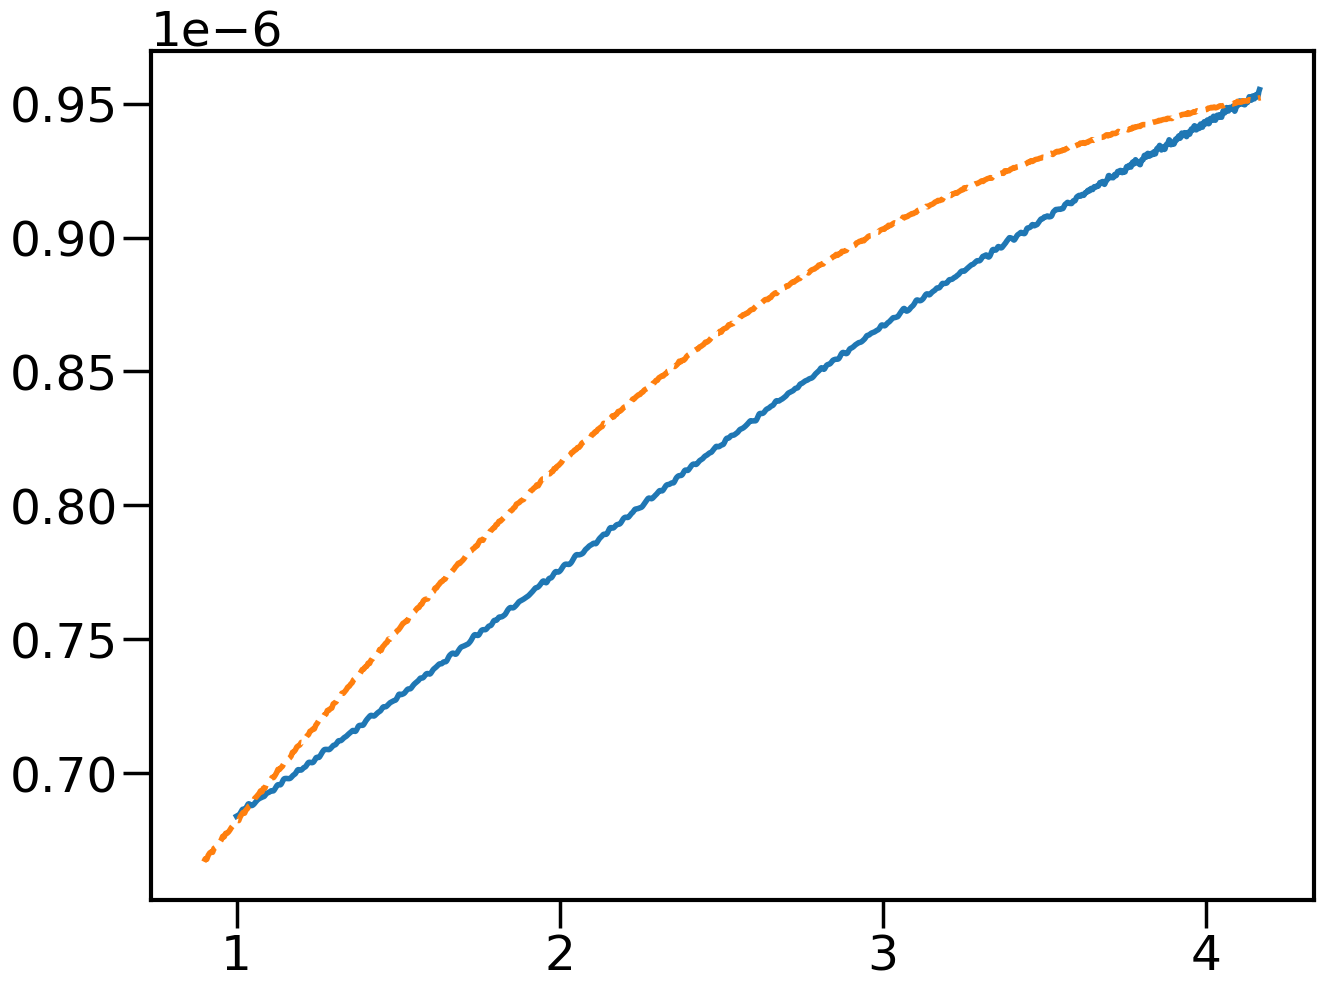

In [137]:
plot(th,th*np.dot(XI_W_L.HT.wig_d[(2,-2)],cls*XI_W_L.HT.norm*dl))
plot(thH/d2r,thH/d2r*xiH/2,'--')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


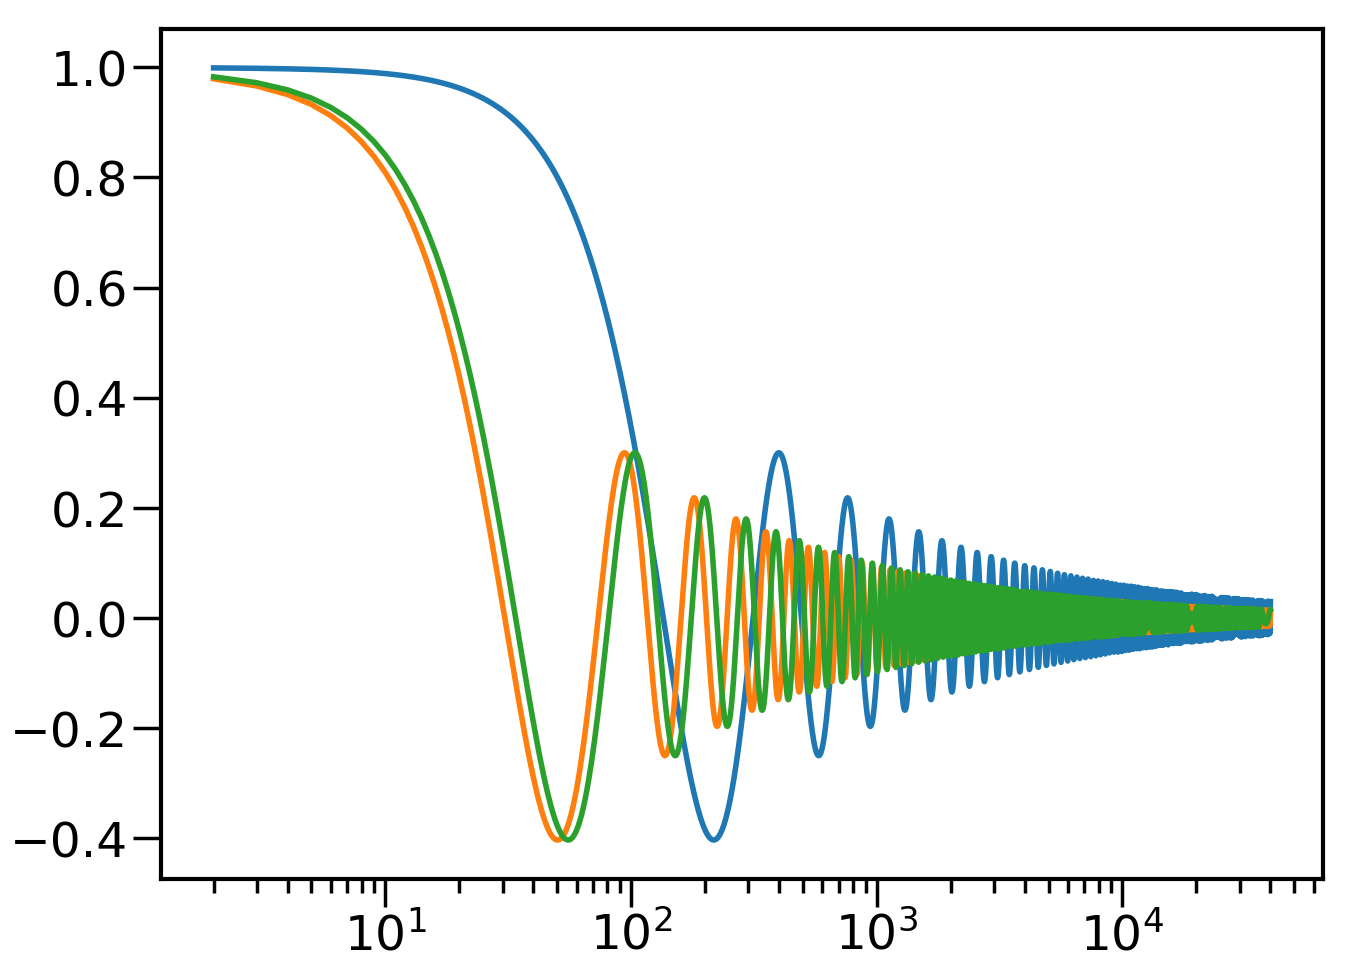

In [139]:
plot(l0,(XI_W_L.HT.wig_d[(2,2)][0,:]))
plot(l0,(XI_W_L.HT.wig_d[(2,2)][-1,:]))
plot(l0,(XI_W_L.HT.wig_d[(2,2)][-200,:]))
xscale('log')
# yscale('log')

In [140]:
%time xiH=xiHG['stack'].compute()
#%time xiH2=xiHG2['stack'].compute()
# %time xiH2=xiHG2['stack'].compute()

CPU times: user 1h 22min 45s, sys: 16.2 s, total: 1h 23min 1s
Wall time: 6min 11s


In [264]:
%time xiW_L=xiWG_L['stack'].compute()

CPU times: user 39min 4s, sys: 29.7 s, total: 39min 34s
Wall time: 2min 50s


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


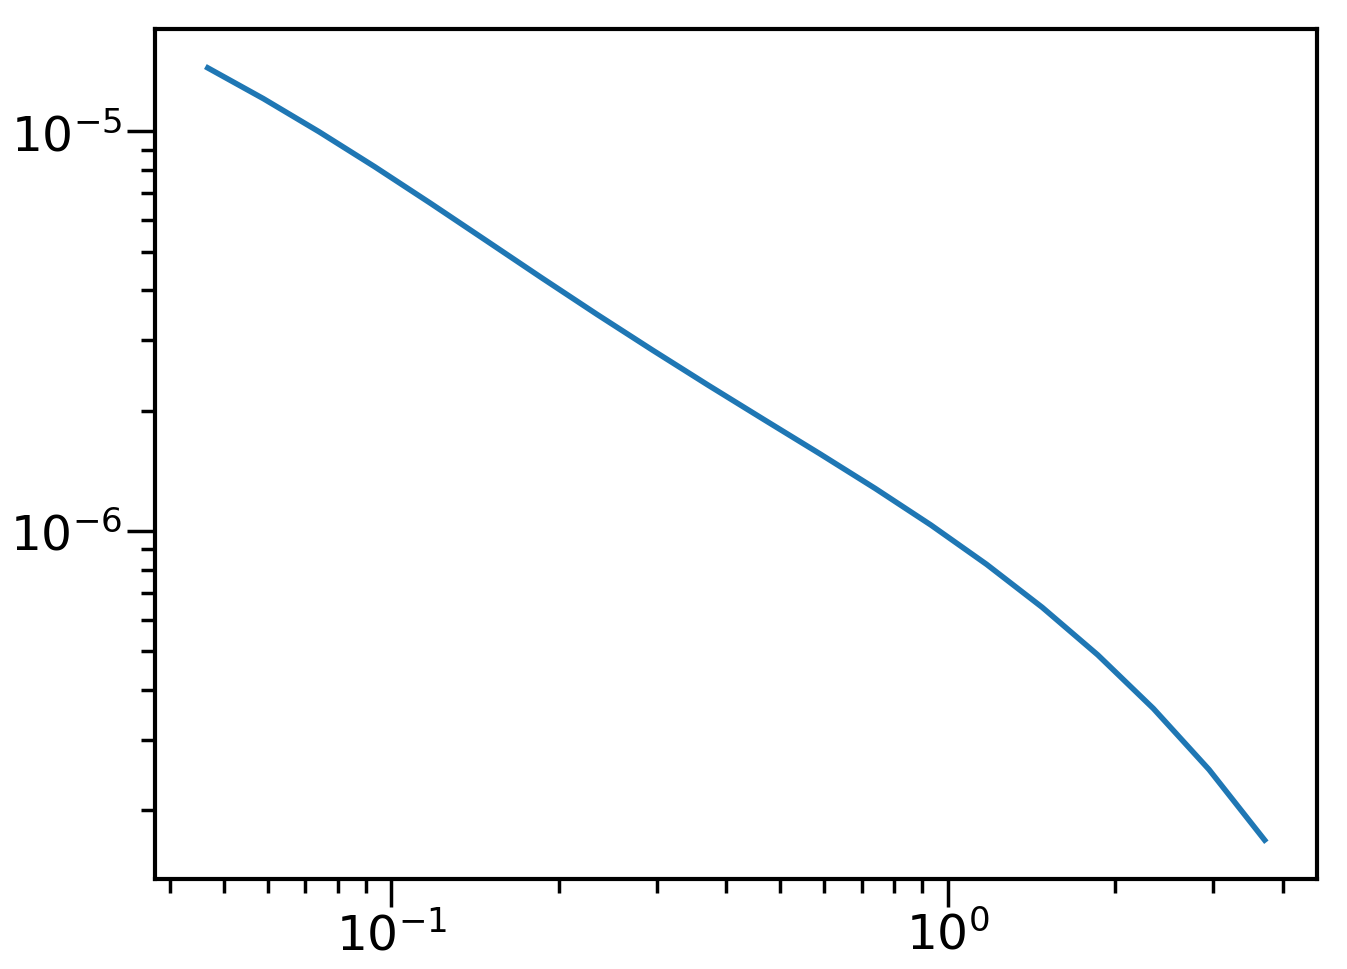

In [265]:
# plot(thb,xiH['xi'][:50])
plot(thb,xiW_L['xi'][:20])
xscale('log')
yscale('log')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


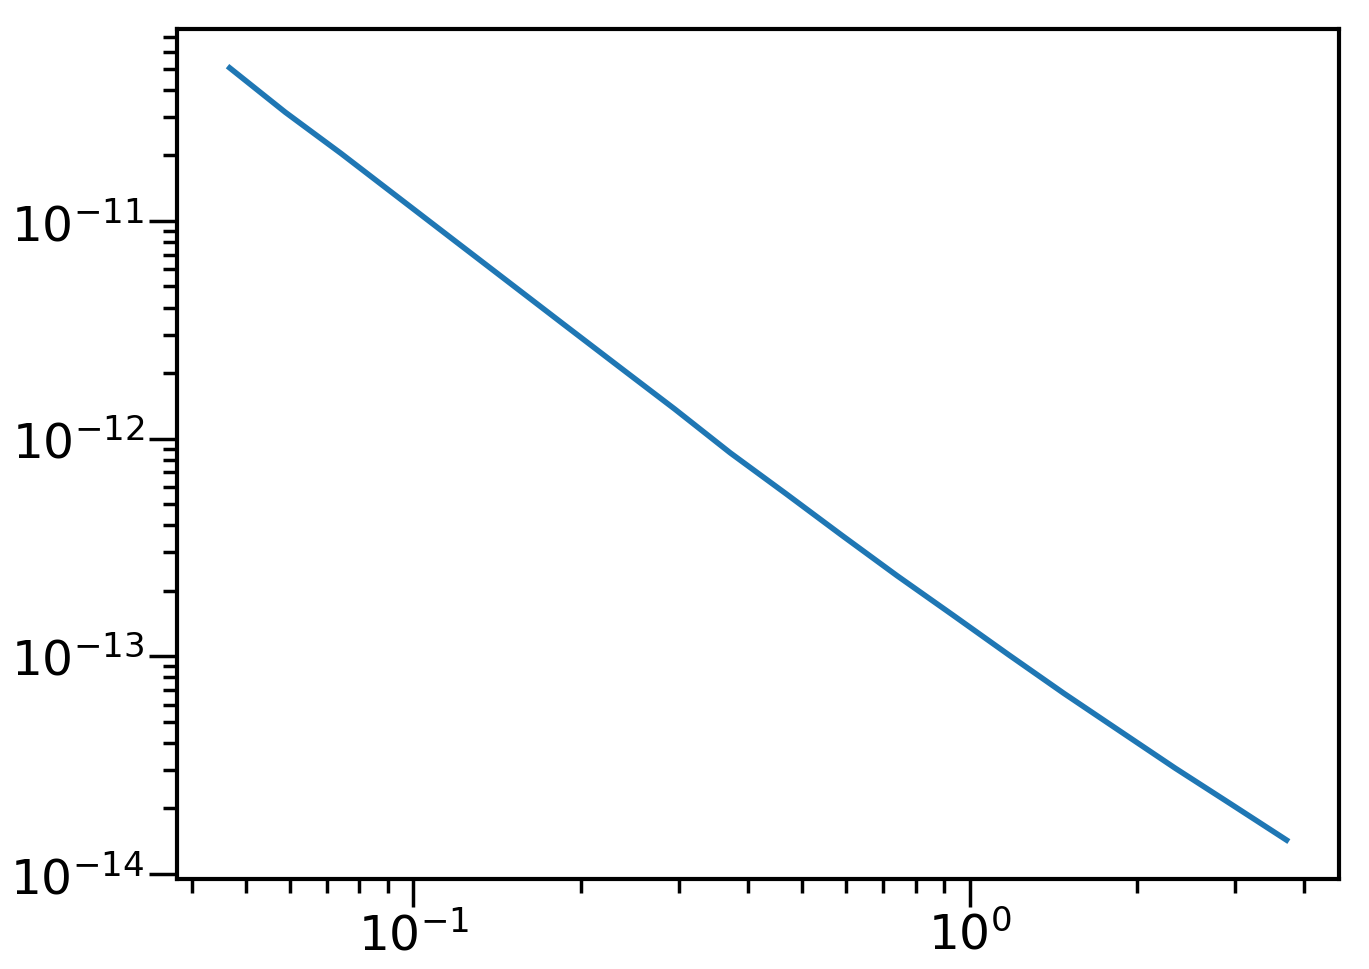

In [266]:
ii=0
i=ii*20
j=i+20
# plot(thb,np.diag(xiH['cov'])[i:j],'--')
plot(thb,np.diag(xiW_L['cov'])[i:j],'-')
xscale('log')
yscale('log')


In [243]:
f=1
cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

32.082268958935316
56.51745963610024


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


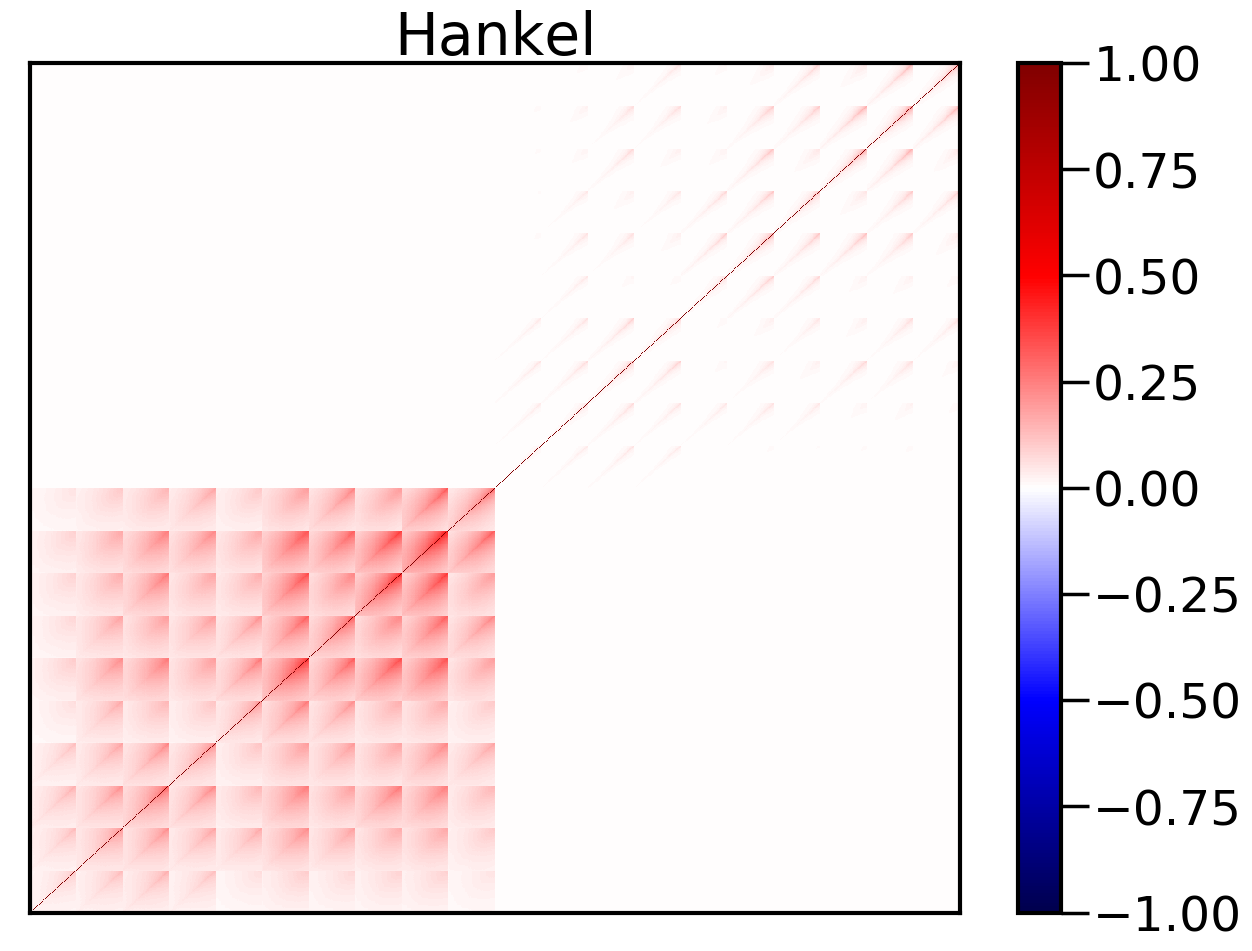

In [143]:
cc=XI_H.cov_utils
corrH=cc.corr_matrix(xiH['cov'])
pcolor(corrH,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Hankel')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


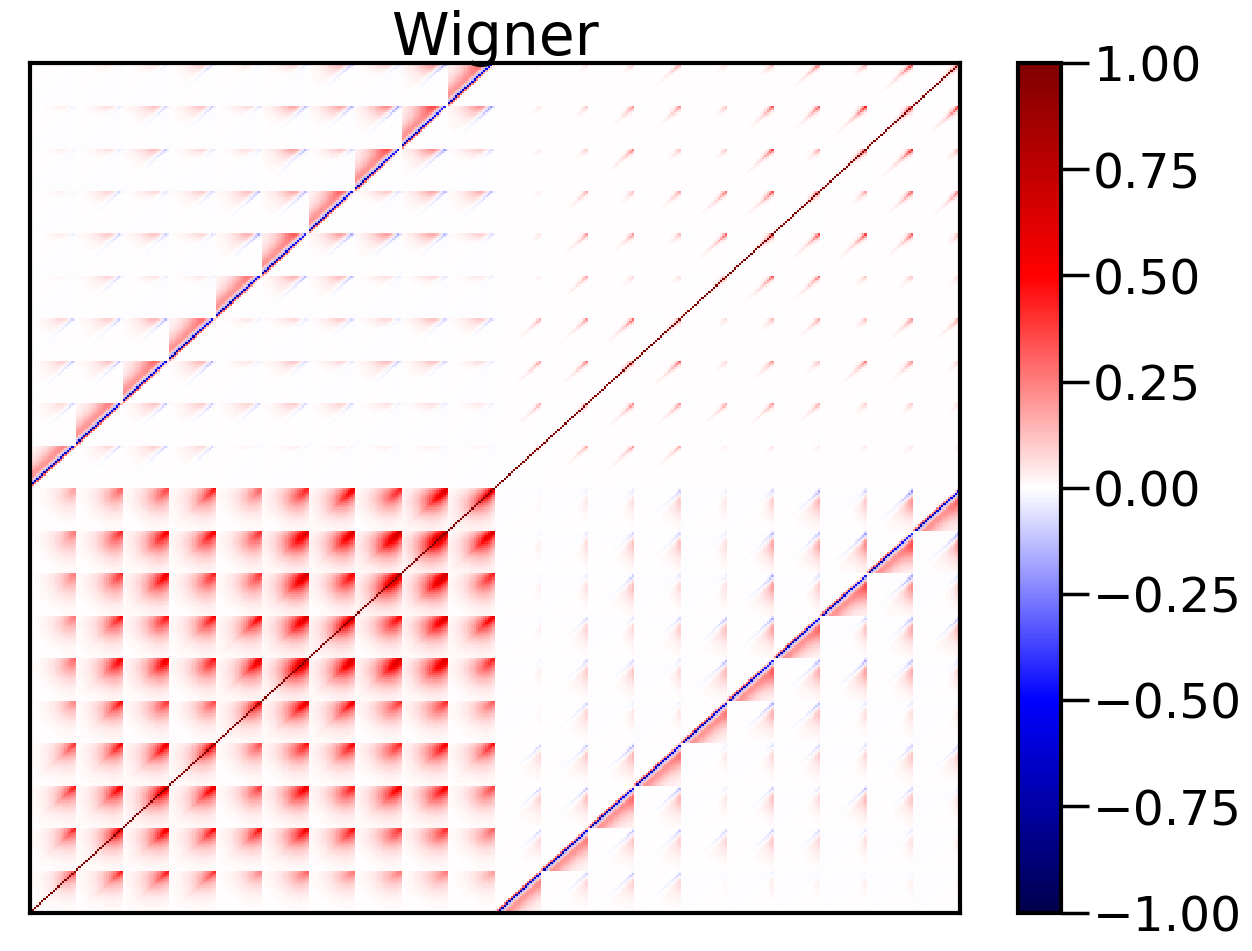

In [183]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


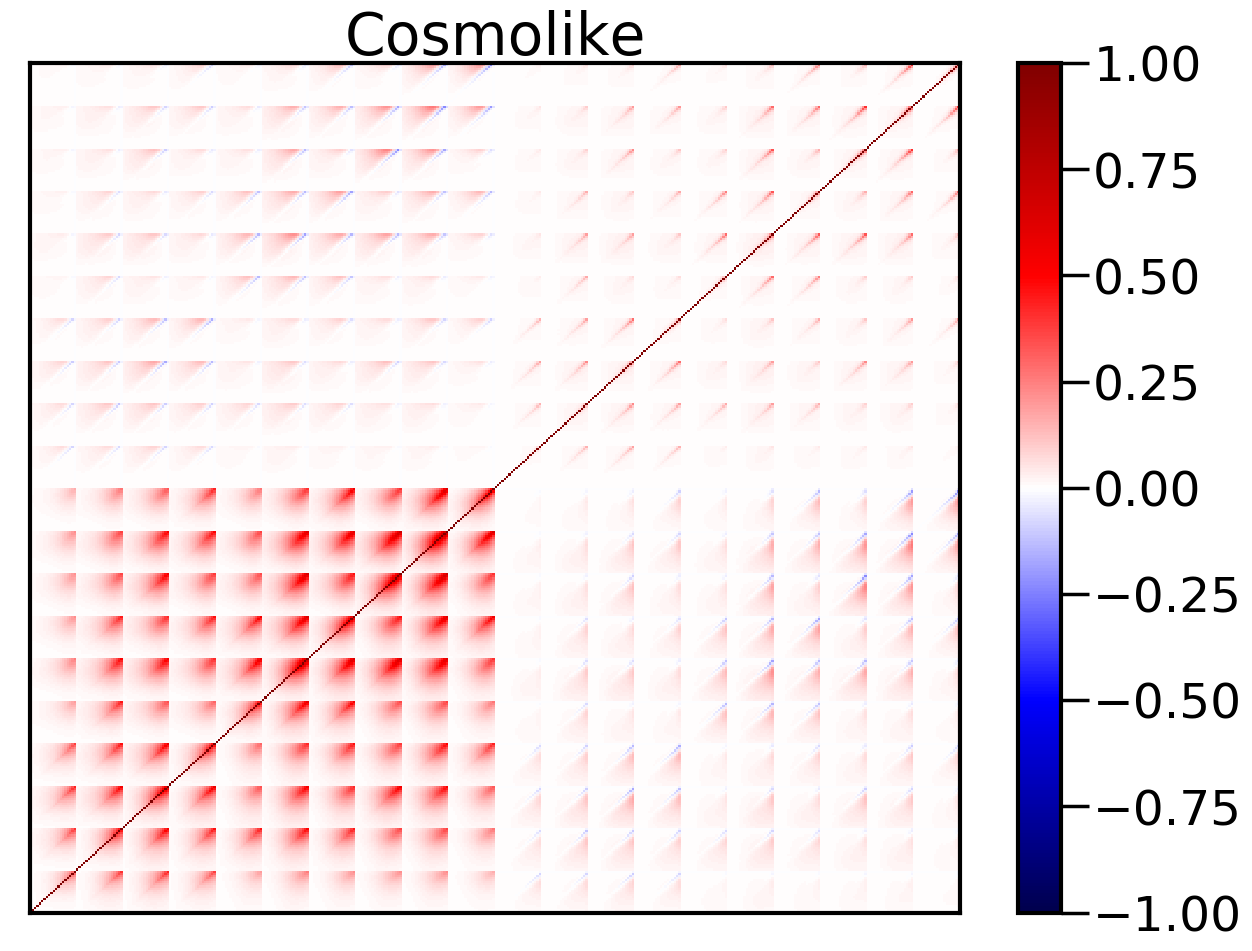

In [36]:
cc=XI_W_L.cov_utils
corr_shear=cc.corr_matrix(covG_shear)
pcolor(corr_shear,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Cosmolike')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


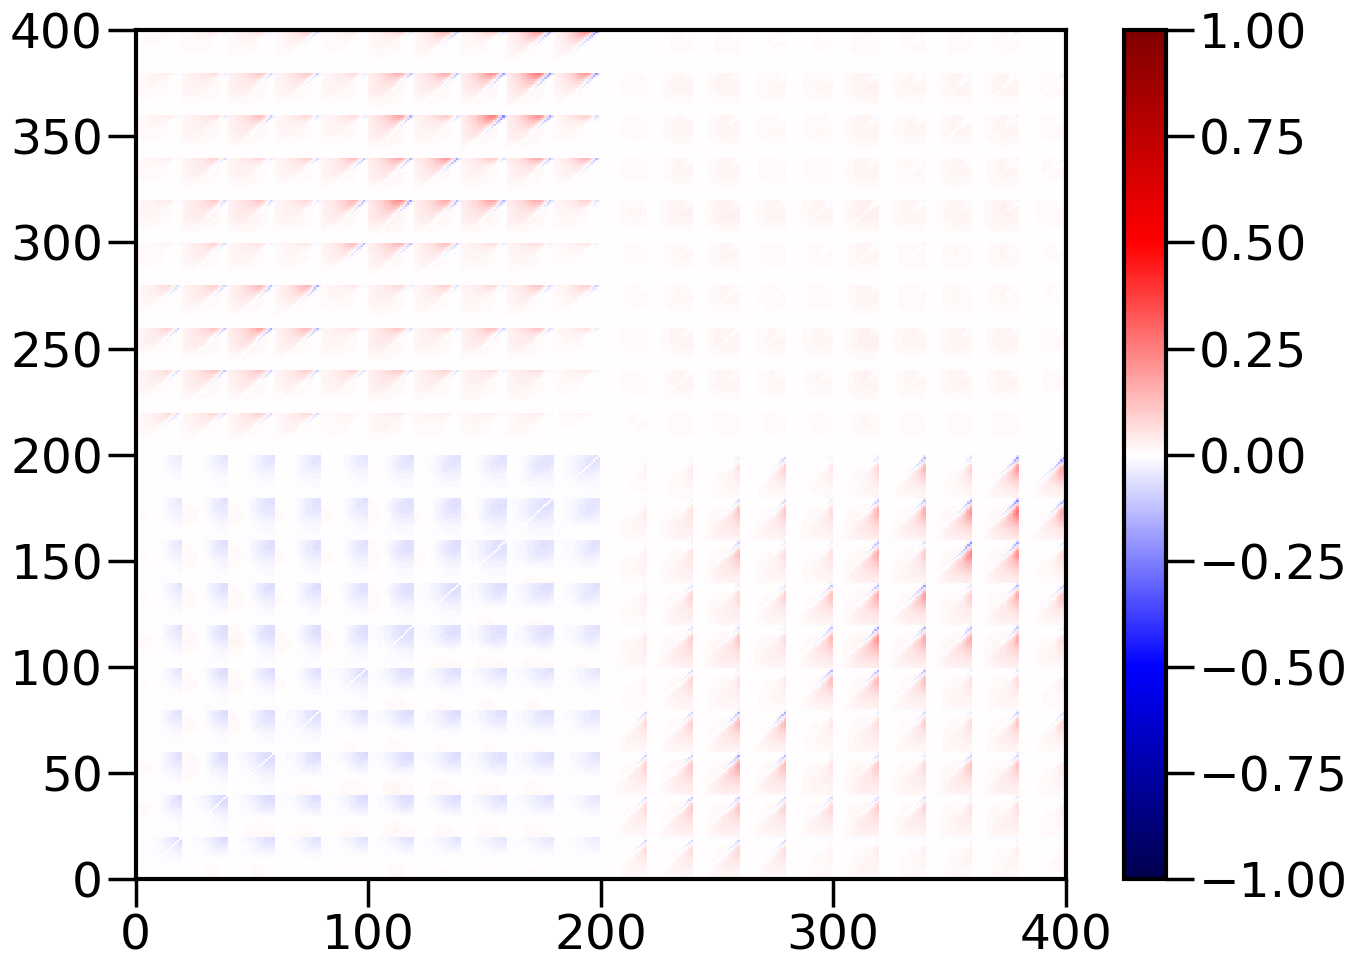

In [37]:
pcolor(corr_shear-corrH,vmin=-1,vmax=1,cmap='seismic')
colorbar()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


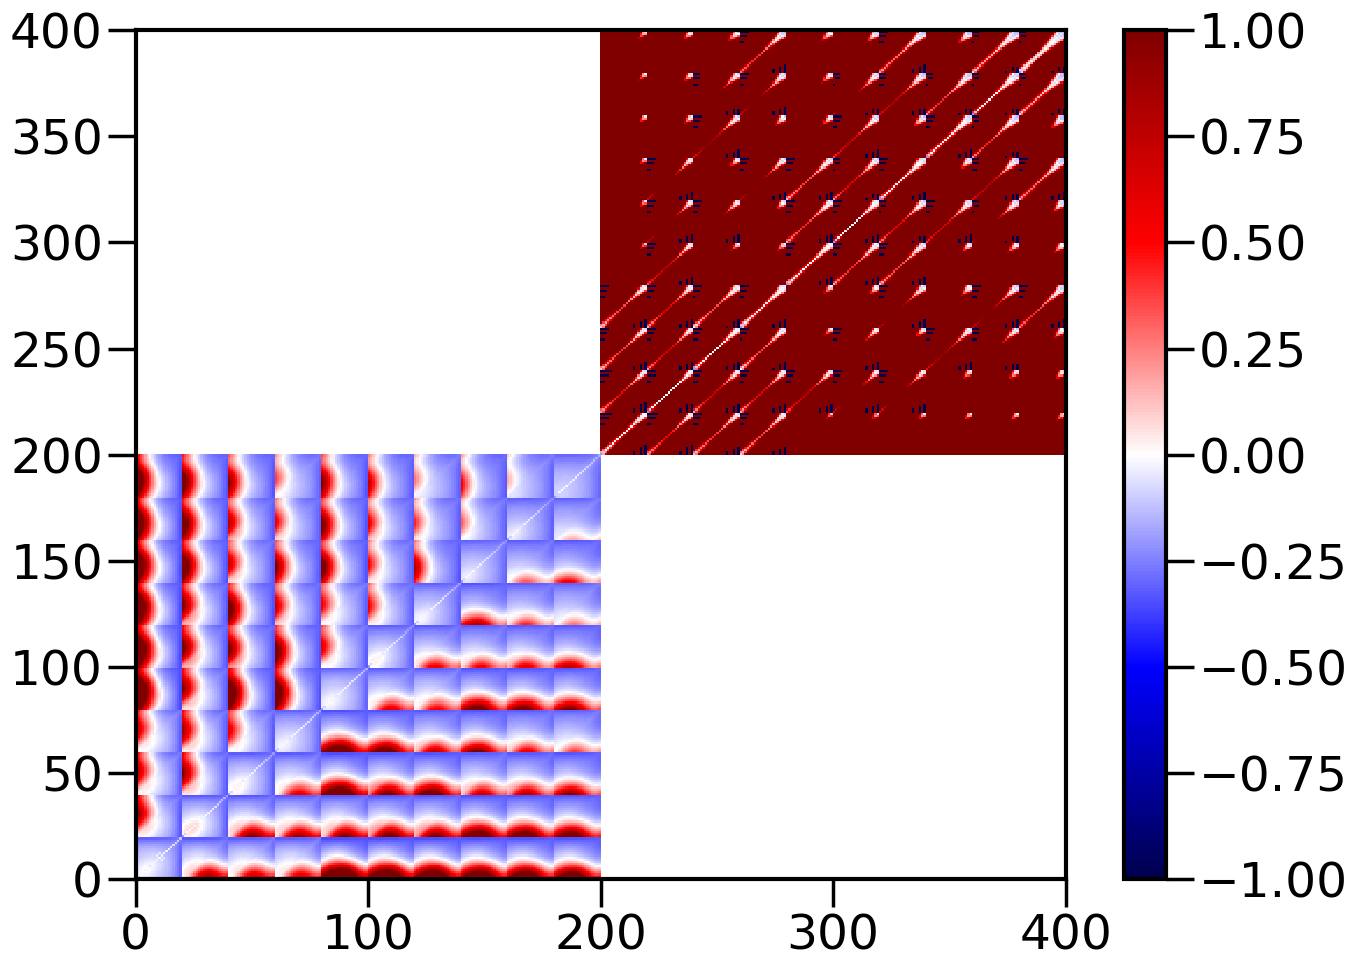

In [38]:
pcolor(cov_shear/xiH['cov']-1,cmap='seismic',vmin=-1,vmax=1,)
colorbar()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


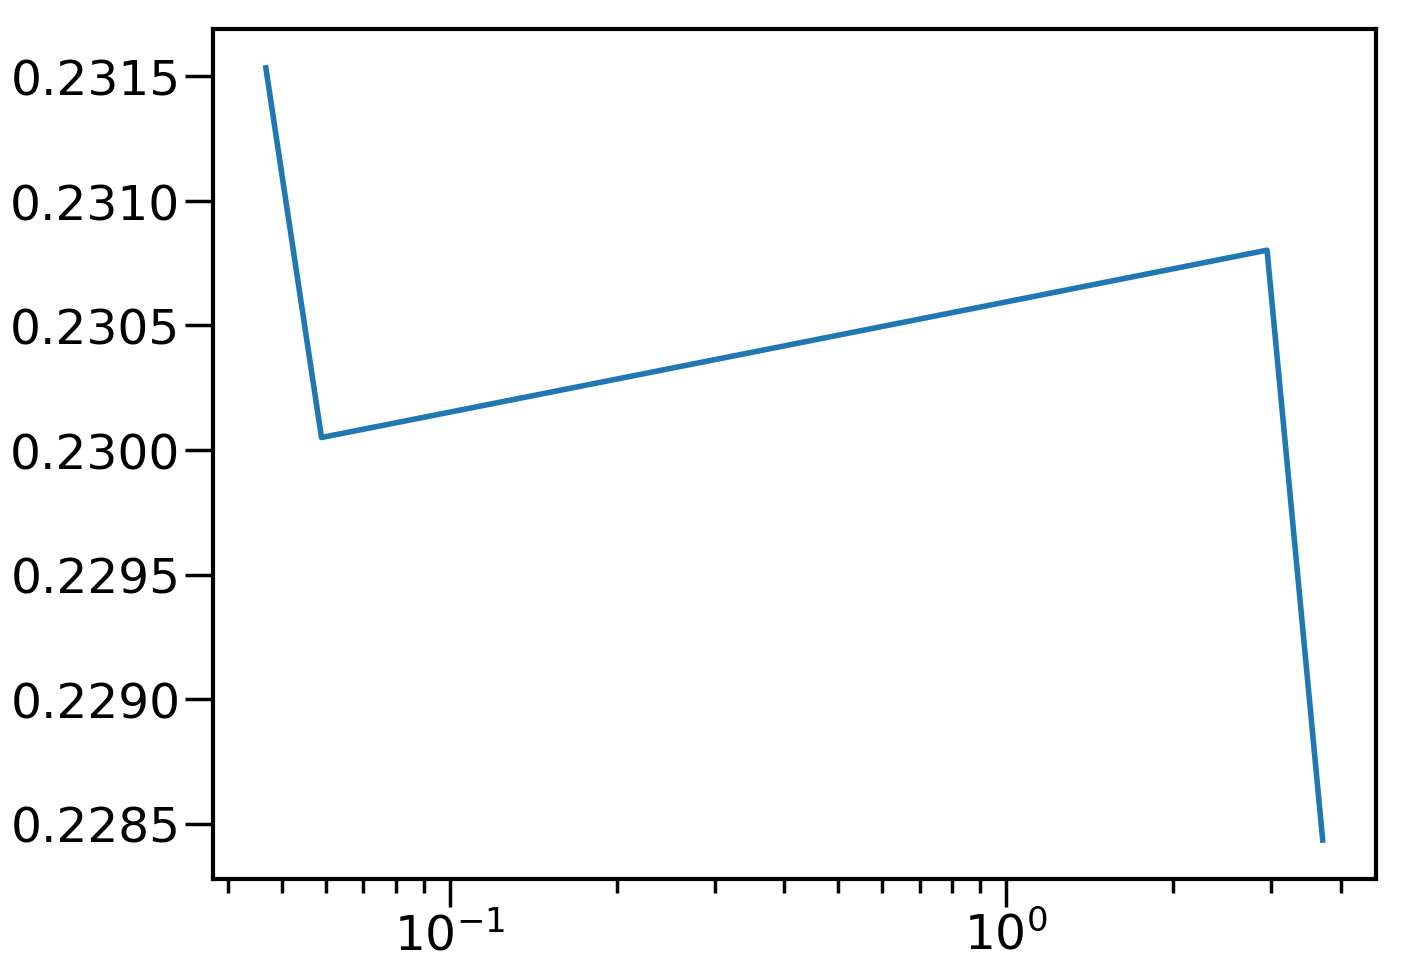

In [39]:
plot(thb,XI_W_L.xi_bin_utils[(2,2)]['norm']/thb**2)
xscale('log')
# yscale('log')

In [40]:
cov_test=np.genfromtxt('shape_noise_cov.dat')
cov_test2=np.genfromtxt('shape_noise_diag.dat')

In [78]:
thb

array([0.04675077, 0.05885573, 0.07409498, 0.09328005, 0.11743262,
       0.14783891, 0.18611816, 0.23430889, 0.29497741, 0.37135456,
       0.46750769, 0.58855731, 0.74094975, 0.93280047, 1.17432622,
       1.47838912, 1.86118163, 2.34308885, 2.9497741 , 3.71354558])

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


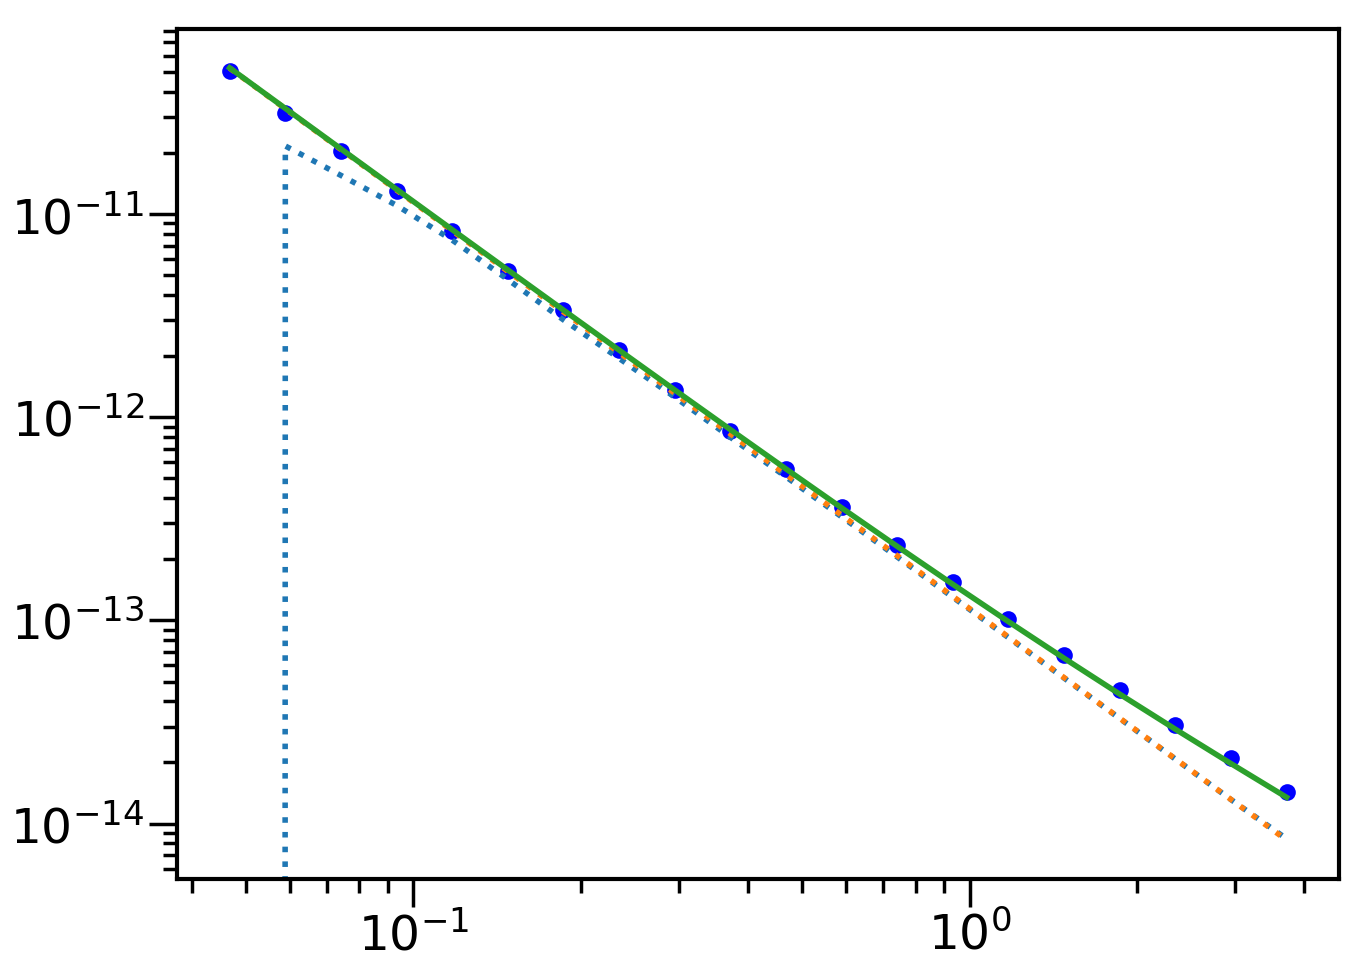

In [267]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
j=i+20
sn=np.diag(cov_shear)[0]/thb**2*thb[0]**2
# NN=np.diag(xiH['cov'])[i:j]-sn/2.
# plot(thb,np.diag(xiH['cov'])[i:j],'--')
# plot(thb,np.diag(xiH2['cov'])[i:j],'--')
plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cov_test),':')
plot(thb,cov_test2,':')
# plot(thb,sn,':')
plot(thb,np.diag(cov_shear)[i:j])
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


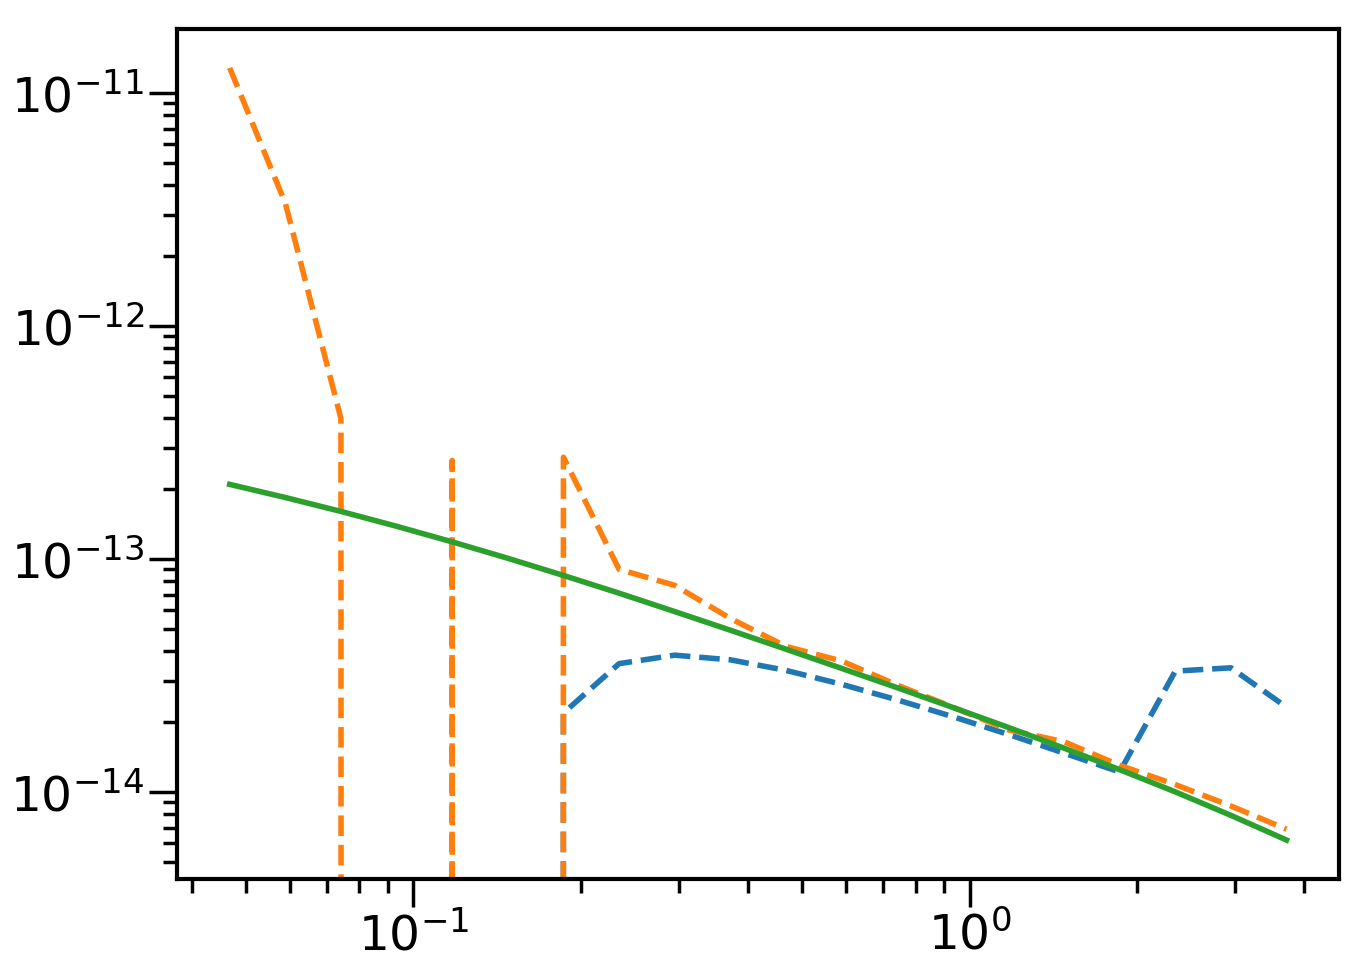

In [55]:
plot(thb,np.diag(xiW_L['cov'])[i:j]-cov_test2,'--')
plot(thb,np.diag(xiH['cov'])[i:j]-cov_test2,'--')
plot(thb,(np.diag(cov_shear)[i:j]-cov_test2)*1.2)

xscale('log')
yscale('log')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


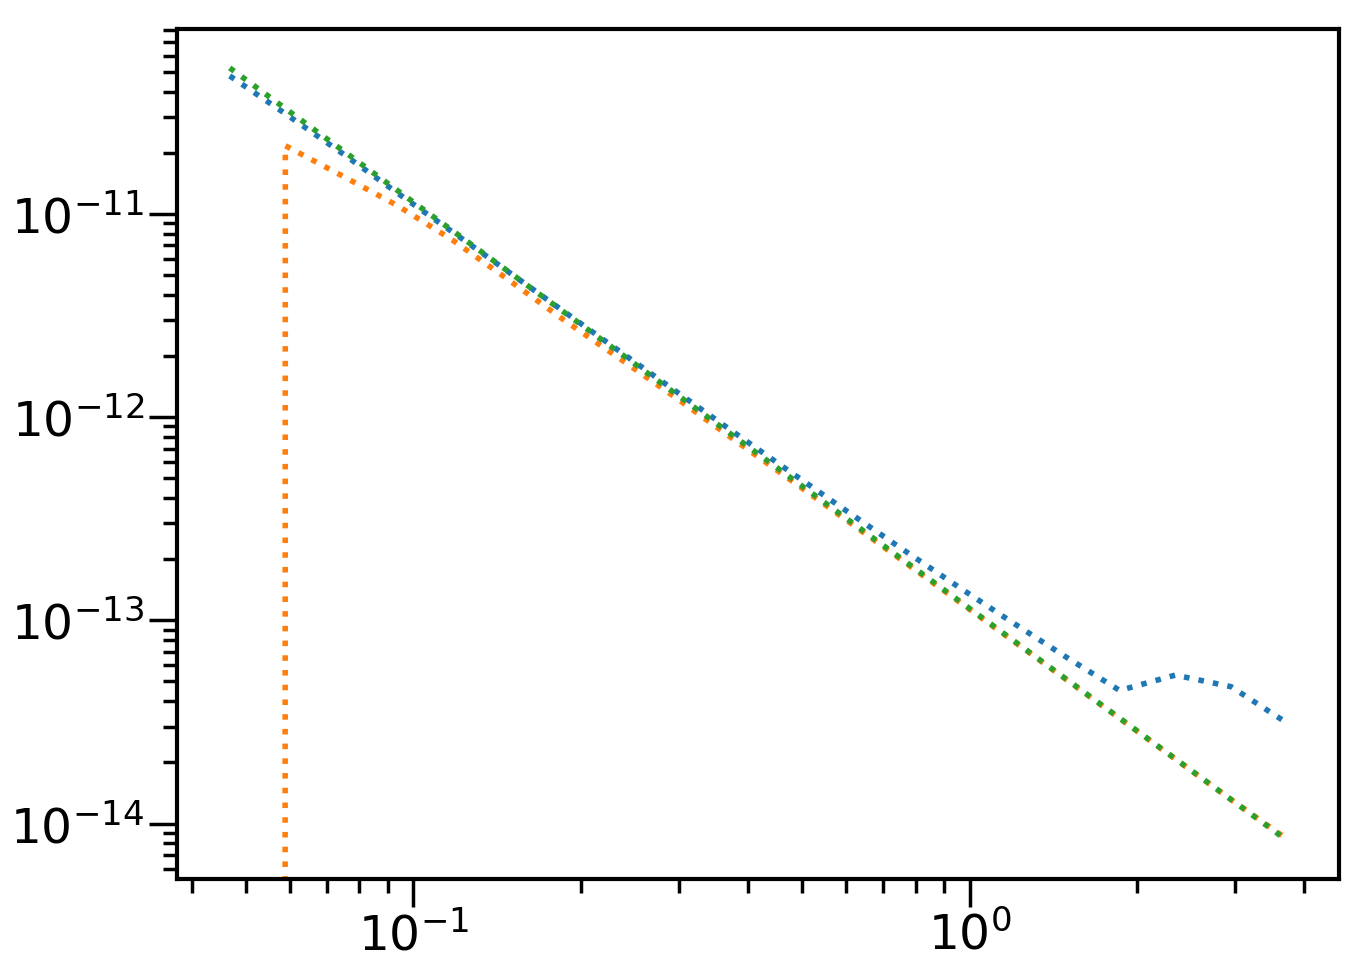

In [43]:
plot(thb,np.diag(xiW_L['cov'])[i:j],':')
plot(thb,np.diag(cov_test),':')
plot(thb,cov_test2,':')

xscale('log')
yscale('log')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


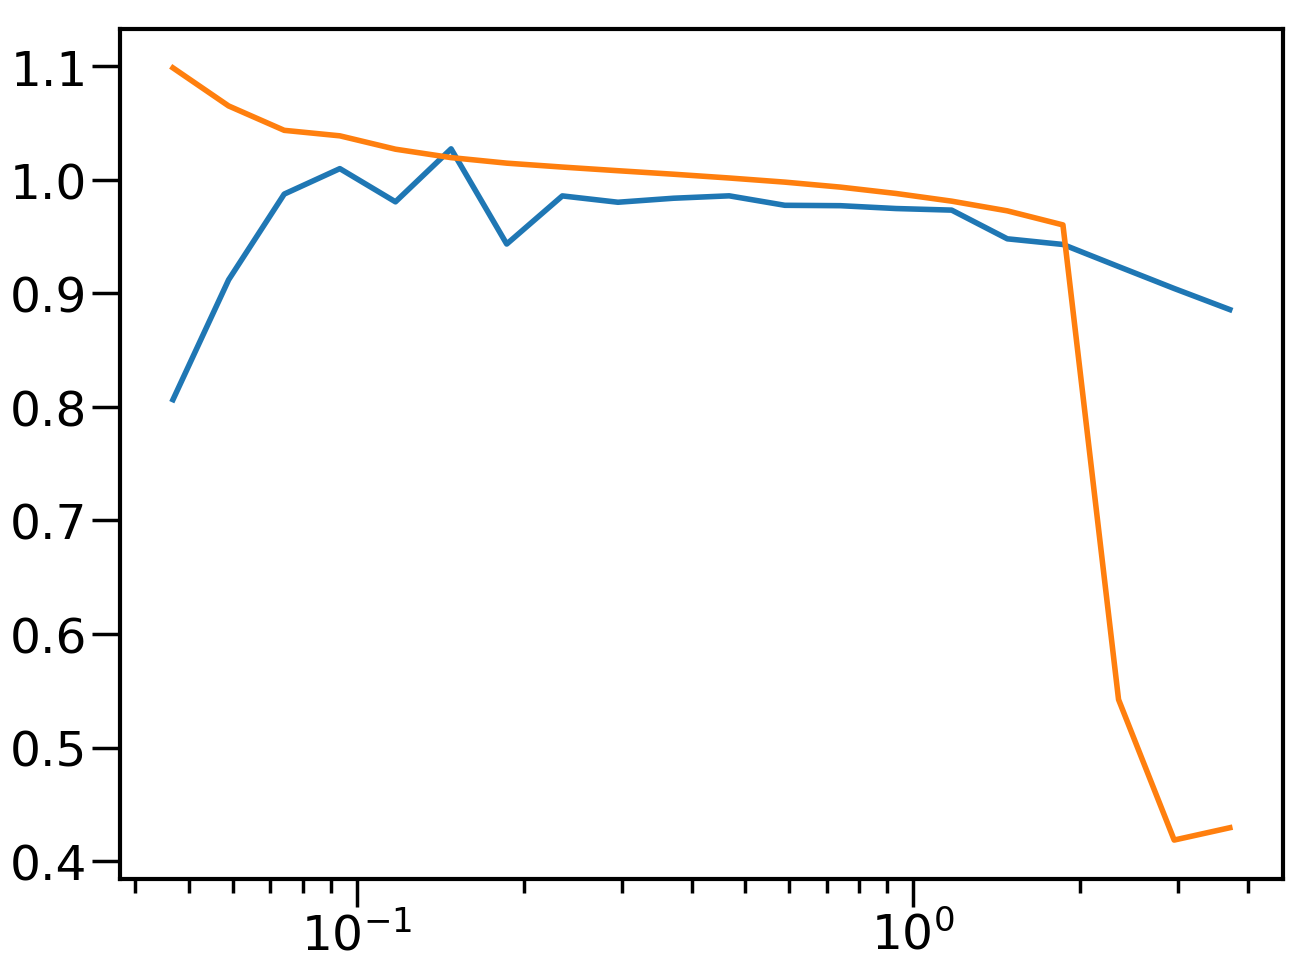

In [44]:
plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
plot(thb,np.diag(cov_shear/xiW_L['cov'])[:20])
xscale('log')
# yscale('log')

In [45]:
d2r/60

0.0002908882086657216

In [46]:
XI_H.z_bins['shear'][0]['nz']

1.496

In [47]:
XI_H.SN

{('shear',
  'shear'): array([[[4.39910631e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 4.33278231e-09, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 4.12631704e-09, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.27910812e-09]]])}

In [48]:
ns=XI_H.z_bins['shear'][0]['nz']*3600/d2r**2
sigma_gamma**2/ns

4.3991063138288594e-09

In [49]:
XI_H.z_bins['shear'][0]['SN']

4.39910631382886e-09

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(0.9, 1.1)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


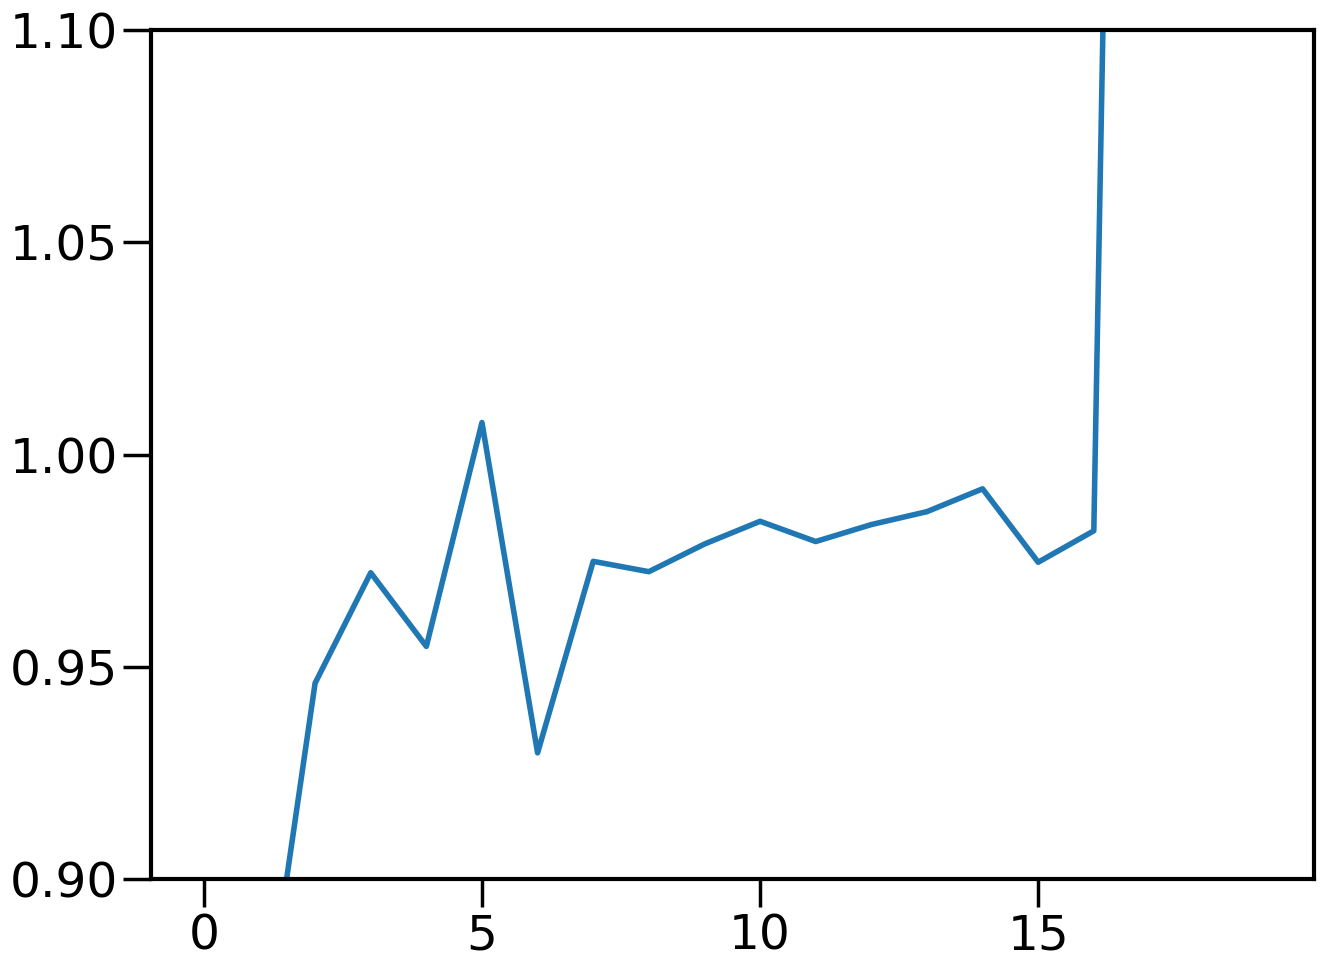

In [50]:
plot(np.diag(xiW_L['cov']/xiH['cov'])[:20])
ylim(0.9,1.1)

In [51]:
crash

NameError: name 'crash' is not defined

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, CL.l)
        plot(CL.l,clG['cl']['cl'][corr][(i,j)].compute()/cls,label=(i,j))
        xscale('log')
#         yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$C_\ell$')
        hlines(1,2,1000)
        legend()
        ylim(0.9,1.1)
    show()

In [ ]:
m1m2=(2,2)
cp=['r','b','g','y']#sns.color_pallete()
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, CL.l)
        cls_b=CL.binning.bin_1d(xi=cls,bin_utils=CL.cl_bin_utils)
        plot(lb,cls_b,color=cp[j],ls=':')
        
    xscale('log')
    yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$')
    legend(ncol=3)
    show()